In [1]:
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.datasets import make_moons, make_blobs

from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import SGDOneClassSVM
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import make_pipeline

matplotlib.rcParams["contour.negative_linestyle"] = "solid"

In [2]:
# Example settings
n_samples = 300
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers

In [3]:
algorithms = [
    ("Robust covariance",
     EllipticEnvelope(contamination=outliers_fraction, random_state=42),
     ),
    ("One-Class SVM",
     svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.1)
     ),
    ("One-Class SVM (SGD)", # the SGDOneClassSVM must be used in a pipeline with a kernel approximation
     make_pipeline(
         Nystroem(gamma=0.1, random_state=42, n_components=150),
         SGDOneClassSVM(
             nu=outliers_fraction,
             shuffle=True,
             fit_intercept=True,
             random_state=42,
             tol=1e-6,
            ),
        ),
     ),
    ("Isolation Forest",
     IsolationForest(contamination=outliers_fraction, random_state=42),
     ),
]

In [4]:
# Create datasets (two dimensions)
blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=2)
datasets = [
    make_blobs(centers=[[0, 0], [0, 0]], cluster_std=0.5, **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[0.5, 0.5], **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[1.5, 0.3], **blobs_params)[0],
    4.0*(make_moons(n_samples=n_samples, noise=0.05, random_state=0)[0] - np.array([0.5, 0.25])),
    14.0*(np.random.RandomState(42).rand(n_samples, 2) - 0.5),
]

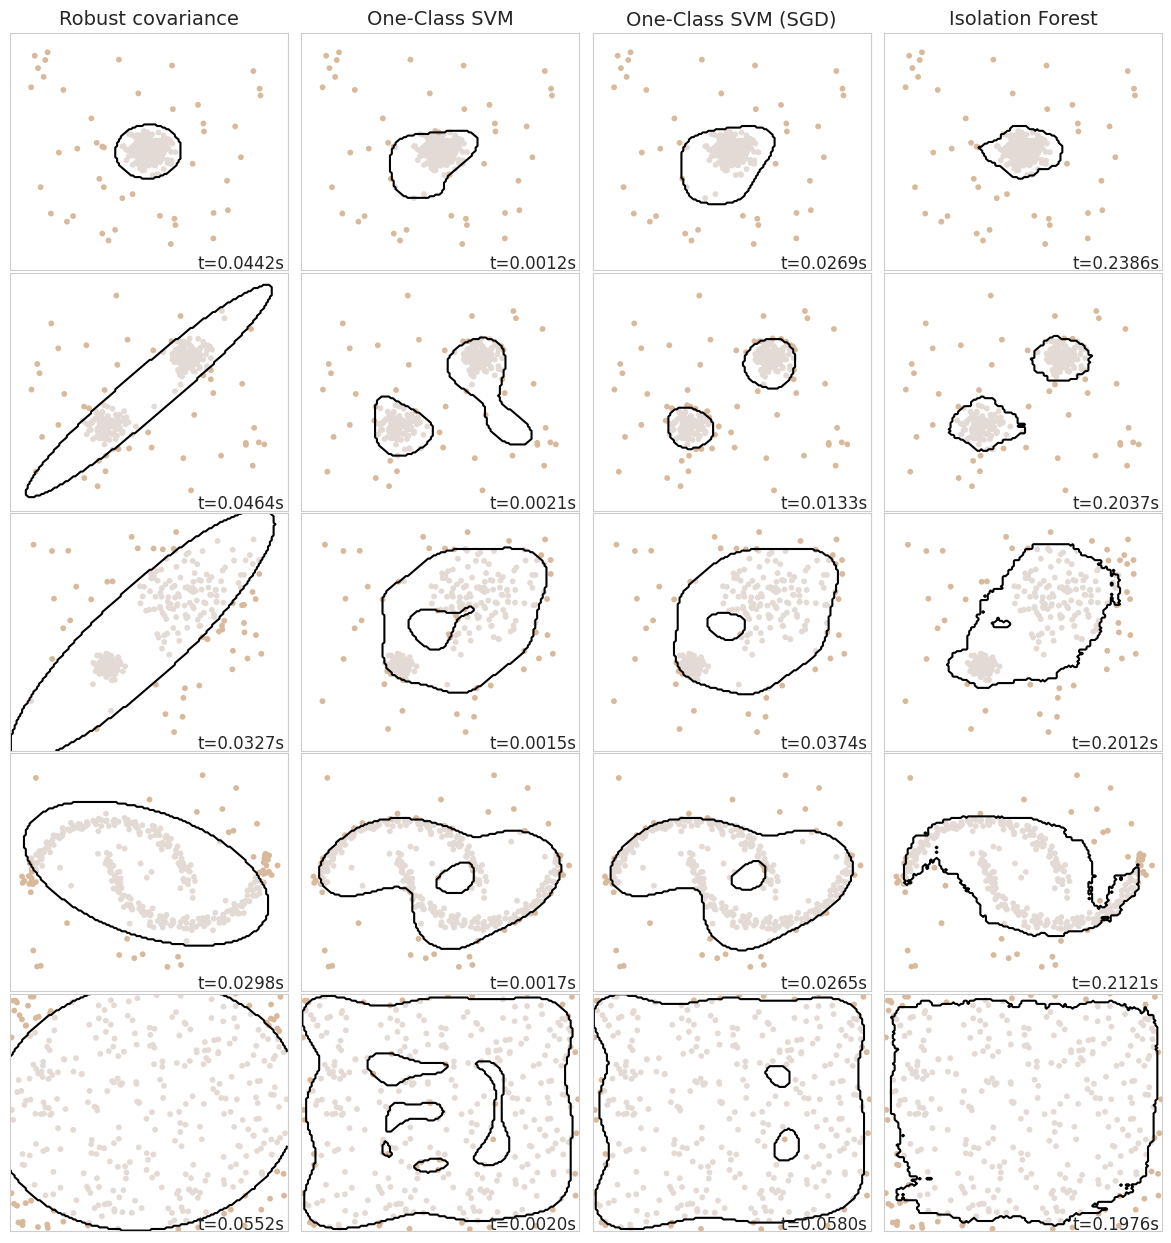

In [5]:
# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 150), np.linspace(-7, 7, 150))

plt.figure(figsize=(len(algorithms)*2 + 4, 12.5))
plt.subplots_adjust(left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.01)

plot_num = 1
rng = np.random.RandomState(42)

for i_dataset, X in enumerate(datasets):
    # Add outliers
    X = np.concatenate([X, rng.uniform(low=-6, high=6, size=(n_outliers, 2))], axis=0)

    for name, algorithm in algorithms:
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        plt.subplot(len(datasets), len(algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=14)

        # fit the data and tag outliers
        y_pred = algorithm.fit_predict(X)

        # plot the levels lines and the points, data ravel array is the same, only black line is different
        Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contour(xx, yy, Z, levels=[0], linewidths=1.5, colors="black")

        colors = np.array(["#d9b99b", "#E3DAD5"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred + 1) // 2])

        plt.xlim(-7, 7)
        plt.ylim(-7, 7)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("t=%.4fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=12,
            horizontalalignment="right",
        )
        plot_num += 1
plt.show()

We can observe that iForest gives similar performance than OneClassSVM but it is slower (more than x10).